In [1]:
import itertools
from pomps.policy_scope import PolicyComponent, MixedPolicyScope
from pomis.scm import *
import networkx as nx
from pomps.contextual_graphs import *
from pomps.policy_scope import *
from pomps.gp_fcm import *
from pomps.controllers import *
import pyro
import torch
from tqdm.auto import tqdm
import pyro.distributions as dist
from pomps.fcm import *
import seaborn as sns
import matplotlib.pyplot as plt
# from pomis.optimiser import CausalOptimiser, Objective, SCM
from pomis.scm import BoolDomain, SCM

In [2]:
def sampler_over():
    u1 = pyro.sample("U1", dist.Uniform(-1, 1))
    u2 = pyro.sample("U2", dist.Uniform(-1, 1))
    return {"U1": u1, "U2": u2}
fcm = FunctionalCausalModel({Functor(lambda U1: pyro.sample("C", dist.Normal(U1, 0.1)), 'C'),
                             Functor(lambda C, U1: pyro.sample("X1", dist.Normal(U1+C, 0.1)), 'X1'),
                             Functor(lambda C, X1, U2: pyro.sample("X2", dist.Normal(C+X1+torch.abs(U2)*0.3, 0.1)), 'X2'),
                             Functor(lambda U2, X2, C: pyro.sample("Y", 
                                        dist.Normal(torch.cos(C-X2)+U2/100, 0.01)), "Y")}, sampler_over)

# def model(count):
#     with pyro.plate("samples", count):
#         age = pyro.sample("age", dist.Uniform(55, 76))
#         bmi = pyro.sample("bmi", dist.Normal(27, 0.7))

#         aspirin_p = torch.sigmoid(-8.0 + 0.10 * age + 0.03 * bmi)
#         statin_p = torch.sigmoid(-13.0 + 0.10 * age + 0.20 * bmi)

#         aspirin = pyro.sample("aspirin", dist.Bernoulli(aspirin_p))
#         statin = pyro.sample("statin", dist.Bernoulli(statin_p))

#         cancer_p = torch.sigmoid(2.2 - 0.05 * age + 0.01 * bmi - 0.04 * statin + 0.02 * aspirin)
#         cancer = pyro.sample("cancer", dist.Bernoulli(cancer_p))

#         mean = 6.8 + 0.04 * age - 0.15 * bmi - 0.60 * statin + 0.55 * aspirin + 1.00 * cancer
#         y = pyro.sample("y", dist.Normal(mean, 0.4))
#     return y
# scm = SCM(model, [BoolDomain('aspirin'), BoolDomain('statin')], non_man={'age', 'bmi', 'cancer'})
# aspirin_graph = scm.induced_graph()
# ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"aspirin", "statin"}, 
#                       contextual_variables={"age", "bmi"}, target='y')
# ccg = MPSDAGController.simplify(ccg)

In [4]:
sum([fcm.sample()["Y"] for i in range(1000)])/1000

tensor(0.4531)

In [80]:
MixedPolicyScope({})

In [79]:
aspirin_graph = fcm.induced_graph()
ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"X1", "X2"}, 
                      contextual_variables={"C", "X1"}, target='Y')
ccg = MPSDAGController.simplify(ccg)
space = [RealDomain("X1", -2, 2), RealDomain("X2", -2, 2), RealDomain("C", -2, 2)]
gpf = GPFunctorFactory(space)

IndentationError: unexpected indent (3062546712.py, line 6)

In [6]:
ccg.interventional_variables, ccg.contextual_variables, ccg.uc_variables

({'X1', 'X2'}, {'C', 'X1'}, {'U1', 'U2'})

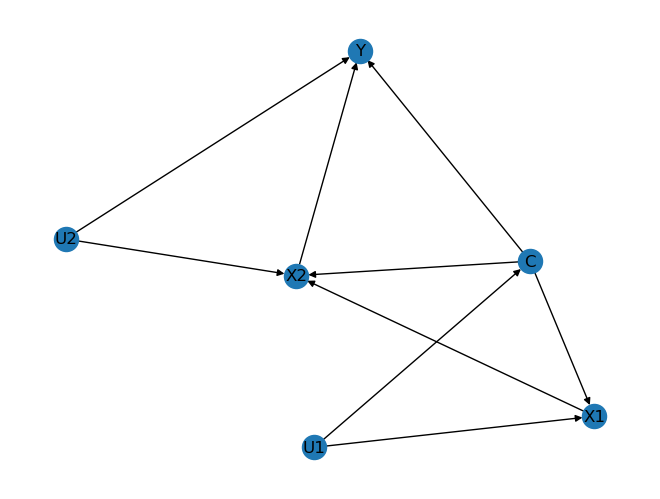

In [7]:
nx.draw(ccg, with_labels=True)

In [8]:
interventional_set = ccg.interventional_variables
contextual_set = ccg.contextual_variables

In [9]:
def all_combs(base, start=0):
    return list(itertools.chain(*[itertools.combinations(base, i) for i in range(start, len(base)+1)]))

def inter_cont_pair_gen(interventional_set, contextual_set):
    inter_segment = []
    context_space = all_combs(contextual_set)
    for inter in interventional_set:
        inter_segment += [[(inter, i) for i in context_space]]
    
    iam = all_combs(inter_segment)
    return itertools.chain(*[(itertools.product(*iam[i])) for i in range(len(iam))], [])

def mpss(pair_gen):
    for mps_row in pair_gen:
        yield MixedPolicyScope({PolicyComponent(target, set(context))  for target, context in mps_row })

In [10]:
a = {1}
b = a
b = b | {2}

In [11]:
a, b

({1}, {1, 2})

In [45]:
type(graph_under_mps[0][1])

pomps.policy_scope.MixedPolicyScope

In [46]:
mpses = list(mpss(inter_cont_pair_gen(interventional_set, contextual_set)))
print(len(mpses))
graph_under_mps = [(MPSDAGController.graph_under_mps(mps, ccg), mps) for mps in mpses]
print(len(graph_under_mps))

graph_under_mps = [(g[0][0], g[1]) for g in graph_under_mps if g[0][1]]
print(len(graph_under_mps))

graph_under_mps = [g for g in graph_under_mps if MPSReductor.action_relevance_check(g[1], g[0]) and MPSReductor.context_relevance_check(g[1], g[0])]
print(len(graph_under_mps))
graph_under_mps = [g for g in graph_under_mps if not MPSReductor.sufficiently_not_pomp(g[1], g[0])]
print(len(graph_under_mps))

25
25
15
set()
call
set()
call
set()
call
{'X1'}
call
{'C'}
call
set()
call
{'X1'} set()
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
{'X2', 'X1'} {'X2', 'X1'}
{'X1'}
call
{'X1'} {'X1'}
{'C'}
call
{'C', 'X1'} {'C'}
{'C', 'X2', 'X1'} {'C', 'X1'}
{'C', 'X2', 'X1'} {'C', 'X1'}
{'C', 'X2', 'X1'} {'C', 'X2', 'X1'}
{'C', 'X2', 'X1'} {'C', 'X2', 'X1'}
set()
call
set()
call
{'X1'}
call
{'C'}
call
{'C', 'X1'} {'C'}
{'C', 'X2', 'X1'} {'C', 'X1'}
{'C', 'X2', 'X1'} {'C', 'X1'}
{'C', 'X2', 'X1'} {'C', 'X2', 'X1'}
{'C', 'X2', 'X1'} {'C', 'X2', 'X1'}
7
set()
call
{'X1'} set()
{'X1'} {'X1'}
set()
call
{'X2'} set()
{'X2'} {'X2'}
{'C'}
call
{'C', 'X2'} {'C'}
{'C', 'X2'} {'C', 'X2'}
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
3


In [13]:
is_single_gp = True

In [14]:
del  graph_under_mps[0]

In [57]:
MixedPolicyScope({}) == graph_under_mps[0][1]

True

In [66]:
list(filter(None, [1,2,None,4,None,6]))

[1, 2, 4, 6]

In [64]:
a.index(MixedPolicyScope({}))

ValueError:  is not in list

In [63]:
a = [mps for _, mps in graph_under_mps]
a.remove(MixedPolicyScope({}))
a.remove(MixedPolicyScope({}))

ValueError: list.remove(x): x not in list

In [16]:
pomps_active = {}
for idx, (graph, mps) in enumerate(graph_under_mps):
    if is_single_gp:
        policy = PolicyFCM.mps_to_single_gp(mps, gpf)
    else:
        policy = PolicyFCM.mps_to_gp_policy(mps, gpf)
    fcm_m = PolicyFCM.fcm_with_policy(fcm, policy)
    pomps_active[idx] = (fcm_m, list(policy)[0], mps)

[{'C'}]
[{'C'}]


In [17]:
# graph, mps = graph_under_mps[-1]
# nx.draw(graph, with_labels=True)
# is_single_gp = True
# if is_single_gp:
#     policy = PolicyFCM.mps_to_single_gp(mps, gpf)
# else:
#     policy = PolicyFCM.mps_to_gp_policy(mps, gpf)
# fcm_m = PolicyFCM.fcm_with_policy(fcm, policy)

In [18]:
 def not_dominated(a, b):
        return (np.asarray(a) <= b).any()

In [19]:
# X = np.random.randn(1000,2)
def not_dominated(a, b):
    return (np.asarray(a) >= b).any()
    
def pareto_optimals(X):
    from scipy.spatial.distance import cdist

    X = cdist(X, X, metric=not_dominated).astype(np.bool)
    non_dominated = np.where(X.all(axis=1))[0]
    return non_dominated

# pareto_optimals(X)

In [20]:
from collections import defaultdict

In [22]:
interv = union([v.interventional_variables for _, _, v in (pomps_active.values())])
arguments = union([v.contextual_variables for _, _, v in (pomps_active.values())])

In [23]:
pomps_active

{0: (<pomps.fcm.FunctionalCausalModel at 0x7fc2a2455340>,
  <X1, {'C'}>),
 1: (<pomps.fcm.FunctionalCausalModel at 0x7fc2a24553d0>,
  <X2, {'C'}>)}

In [77]:
pomps_active

{0: (<pomps.fcm.FunctionalCausalModel at 0x7fc2a2455340>,
  <X1, {'C'}>),
 1: (<pomps.fcm.FunctionalCausalModel at 0x7fc2a24553d0>,
  <X2, {'C'}>)}

In [25]:
results = defaultdict(lambda: [])
for i in tqdm(range(1000)):
    print("-"*50)
    trial_index = None
    try:
        trial_index = [idx for idx, (f, p, _) in enumerate(pomps_active.values()) if p.acq_vals is None][0]
        print("None detected")
    except IndexError as _:
        fold = np.row_stack([p.acq_vals for f, p, _ in pomps_active.values()])
        print("Folds", fold)
        optimals = pareto_optimals(fold)
        print("Optimals", optimals)
        trial_index = np.random.choice(optimals)
#     trial_index=0
    results['trial_id'].append(trial_index)
    
    fcm_m, policy, mps = pomps_active[trial_index]
    if is_single_gp:
            print("Policy for", policy.variable, policy.arguments)

    print("Trial index", trial_index)
    smp = fcm_m.sample(necessary_context=policy.arguments)
    print(smp)

    print("Acq vals", policy.acq_vals)
    for arg in arguments:
        if arg in mps.contextual_variables:
            results[f"arg_{arg}"].append(torch.tensor([smp[arg]]).item())
        else:
            results[f"arg_{arg}"].append(None)
    for var in interv:
        if var in mps.interventional_variables:
            results[f"int_{var}"].append(torch.tensor([smp[var]]).item())
        else:
            results[f"int_{var}"].append(None)
    y = smp[graph.target]
    y = torch.tensor([y])
    
    results['Y'].append(y.item())

    if is_single_gp:
        policy.functional.observe(-y)
    else:
        for p in policy:
            p.functional.observe(-y)


  0%|          | 0/1000 [00:00<?, ?it/s]

--------------------------------------------------
None detected
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.0078)} {'U1': tensor(-0.0495), 'U2': tensor(0.7183), 'C': tensor(-0.0078)} {'C'} {'C'} X1
{'C': tensor(-0.0078), 'X1': -2.0, 'X2': tensor(-1.8149), 'Y': tensor(-0.2288)}
Acq vals None
--------------------------------------------------
None detected
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.2937)} {'U1': tensor(0.2929), 'U2': tensor(0.3292), 'C': tensor(0.2937)} {'C'} {'C'} X1
{'C': tensor(0.2937), 'X1': 0.0, 'X2': tensor(0.3437), 'Y': tensor(1.0172)}
Acq vals None
--------------------------------------------------
None detected
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.7992)} {'U1': tensor(0.7612), 'U2': tensor(0.1663), 'C': tensor(0.7992)} {'C'} {'C'} X1
{'C': tensor(0.7992), 'X1': 1.0, 'X2': tensor(1.8385), 'Y': tensor(0.5003)}
Acq vals None
--------------------------------------------------
None detected
Policy for X1 {'C'}
Tr

buffer {}
{'C': tensor(0.6383)} {'U1': tensor(0.6617), 'U2': tensor(0.2772), 'C': tensor(0.6383), 'X2': 0.23051126790837495} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.6383), 'X2': 0.23051126790837495, 'X1': 0.127195620708211, 'Y': tensor(0.9087)}
Acq vals [[ 2.1659193  -7.2705307  -5.49663162]]
--------------------------------------------------
Folds [[ 1.40492892e+00 -7.44711995e-01 -1.57357499e-05]
 [ 2.16591930e+00 -7.27053070e+00 -5.49663162e+00]]
Optimals [0 1]
Policy for X2 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.2380)} {'U1': tensor(0.3229), 'U2': tensor(-0.8237), 'C': tensor(0.2380)} {'C'} {'C'} X2
fitting GP
buffer {}
{'C': tensor(0.2380)} {'U1': tensor(0.3229), 'U2': tensor(-0.8237), 'C': tensor(0.2380), 'X2': 0.12338061136178963} {'C'} {'C'} X1
{'C': tensor(0.2380), 'X2': 0.12338061136178963, 'X1': 0.025208422798259536, 'Y': tensor(1.0132)}
Acq vals [[ 2.61244369 -1.34232593 -0.49994221]]
--------------------------------------------------
Folds [[ 1.67511523 -1.53629005 

{'C': tensor(0.9650), 'X2': 0.7449196446122621, 'X1': -0.534418972236181, 'Y': tensor(0.9797)}
Acq vals [[ 2.37859058 -1.30787361 -0.39856765]]
--------------------------------------------------
Folds [[ 1.90065181 -2.87901211 -1.33454478]
 [ 2.37859058 -1.30787361 -0.39856765]]
Optimals [1]
Policy for X2 {'C'}
Trial index 1
buffer {}
{'C': tensor(0.0104)} {'U1': tensor(-0.0857), 'U2': tensor(-0.1804), 'C': tensor(0.0104)} {'C'} {'C'} X2
fitting GP
buffer {}
{'C': tensor(0.0104)} {'U1': tensor(-0.0857), 'U2': tensor(-0.1804), 'C': tensor(0.0104), 'X2': -0.10411802292054913} {'C'} {'C'} X1
{'C': tensor(0.0104), 'X2': -0.10411802292054913, 'X1': 0.43206357955932617, 'Y': tensor(0.9926)}
Acq vals [[ 2.45286274 -1.91019857 -0.60050952]]
--------------------------------------------------
Folds [[ 1.5150677  -1.54743183 -0.38089636]
 [ 2.45286274 -1.91019857 -0.60050952]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.9227)} {'U1': tensor(-0.7314), 'U2': tensor(0.

{'C': tensor(-0.7611), 'X2': -0.6053907760879402, 'X1': 0.33207214714535016, 'Y': tensor(1.0068)}
Acq vals [[ 1.68414664 -4.97196007 -2.25074792]]
--------------------------------------------------
Folds [[ 1.84702814 -1.21735287 -0.1980561 ]
 [ 1.68414664 -4.97196007 -2.25074792]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.7036)} {'U1': tensor(0.7992), 'U2': tensor(-0.2184), 'C': tensor(0.7036)} {'C'} {'C'} X1
{'C': tensor(0.7036), 'X1': -0.3659395112495908, 'X2': tensor(0.3809), 'Y': tensor(0.9335)}
Acq vals [[ 1.50818133 -0.79652566 -0.00591798]]
--------------------------------------------------
Folds [[ 1.50818133 -0.79652566 -0.00591798]
 [ 1.68414664 -4.97196007 -2.25074792]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.0183)} {'U1': tensor(0.0315), 'U2': tensor(-0.3848), 'C': tensor(-0.0183)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.0183), 'X1': 0.3042930735106438, 'X2': tensor(0.4187), 'Y': tensor(0.9089)}
Acq vals [[

buffer {}
{'C': tensor(0.0507)} {'U1': tensor(-0.0252), 'U2': tensor(0.9661), 'C': tensor(0.0507), 'X2': -0.14718748202028076} {'C'} {'C'} X1
{'C': tensor(0.0507), 'X2': -0.14718748202028076, 'X1': -0.19915198080659208, 'Y': tensor(0.9845)}
Acq vals [[ 1.40614688 -2.63822865 -0.47662339]]
--------------------------------------------------
Folds [[ 2.10492635 -2.14665532 -0.36821571]
 [ 1.40614688 -2.63822865 -0.47662339]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.5242)} {'U1': tensor(0.7001), 'U2': tensor(-0.0589), 'C': tensor(0.5242)} {'C'} {'C'} X1
{'C': tensor(0.5242), 'X1': -0.13061792017955443, 'X2': tensor(0.1983), 'Y': tensor(0.9504)}
Acq vals [[ 0.99717212 -1.12172329 -0.01493803]]
--------------------------------------------------
Folds [[ 0.99717212 -1.12172329 -0.01493803]
 [ 1.40614688 -2.63822865 -0.47662339]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.9838)} {'U1': tensor(0.9740), 'U2': tensor(0.8555), 'C': tens

{'C': tensor(-0.4298), 'X1': -0.17957600223793446, 'X2': tensor(-0.3370), 'Y': tensor(0.9844)}
Acq vals [[ 2.36356306 -0.74004334 -0.01821387]]
--------------------------------------------------
Folds [[ 2.36356306 -0.74004334 -0.01821387]
 [ 1.55546355 -2.43451381 -0.49127978]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.6048)} {'U1': tensor(0.6414), 'U2': tensor(0.9749), 'C': tensor(0.6048)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.6048), 'X1': -0.1176111845547409, 'X2': tensor(0.8019), 'Y': tensor(0.9887)}
Acq vals [[ 2.48784351 -1.12073815 -0.08644276]]
--------------------------------------------------
Folds [[ 2.48784351 -1.12073815 -0.08644276]
 [ 1.55546355 -2.43451381 -0.49127978]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.5752)} {'U1': tensor(0.4743), 'U2': tensor(0.2224), 'C': tensor(0.5752)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.5752), 'X1': -0.0832060709743071, 'X2': tensor(0.6710), 'Y': tensor(1.0075)}
Acq vals 

{'C': tensor(-0.3064), 'X1': -0.18344185074784905, 'X2': tensor(-0.5013), 'Y': tensor(0.9820)}
Acq vals [[ 2.04029846e+00  5.43094426e-03 -4.76848545e-05]]
--------------------------------------------------
Folds [[ 2.04029846e+00  5.43094426e-03 -4.76848545e-05]
 [ 1.51062608e+00 -5.68445253e+00 -2.86822033e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.8439)} {'U1': tensor(-0.8663), 'U2': tensor(0.7654), 'C': tensor(-0.8439)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.8439), 'X1': -0.15423903943455744, 'X2': tensor(-0.9875), 'Y': tensor(0.9852)}
Acq vals [[ 2.23332787e+00 -4.86696921e-02 -1.18977950e-04]]
--------------------------------------------------
Folds [[ 2.23332787e+00 -4.86696921e-02 -1.18977950e-04]
 [ 1.51062608e+00 -5.68445253e+00 -2.86822033e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.3087)} {'U1': tensor(-0.3121), 'U2': tensor(0.5533), 'C': tensor(-0.3087)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.3087

{'C': tensor(0.0117), 'X1': -0.055510045570056496, 'X2': tensor(0.3979), 'Y': tensor(0.9191)}
Acq vals [[ 2.32634354e+00  2.23734081e-01 -6.61613740e-06]]
--------------------------------------------------
Folds [[ 2.32634354e+00  2.23734081e-01 -6.61613740e-06]
 [ 1.58364916e+00 -2.10467839e+00 -4.70029384e-01]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.2243)} {'U1': tensor(-0.1245), 'U2': tensor(0.1501), 'C': tensor(-0.2243)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.2243), 'X1': -0.1783776884109527, 'X2': tensor(-0.2620), 'Y': tensor(1.0031)}
Acq vals [[ 3.1611414  -1.8152113  -0.51475298]]
--------------------------------------------------
Folds [[ 3.1611414  -1.8152113  -0.51475298]
 [ 1.58364916 -2.10467839 -0.47002938]]
Optimals [0 1]
Policy for X2 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.1486)} {'U1': tensor(-0.2224), 'U2': tensor(0.8145), 'C': tensor(-0.1486)} {'C'} {'C'} X2
fitting GP
buffer {}
{'C': tensor(-0.1486)} {'U1': tensor(-0.2224),

buffer {}
{'C': tensor(0.0398)} {'U1': tensor(-0.0812), 'U2': tensor(-0.5551), 'C': tensor(0.0398), 'X2': 0.02669474857779356} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.0398), 'X2': 0.02669474857779356, 'X1': -0.16419331356034855, 'Y': tensor(0.9893)}
Acq vals [[ 1.32207048 -2.36566639 -0.26570055]]
--------------------------------------------------
Folds [[ 3.19203091 -0.12157393 -0.00605104]
 [ 1.32207048 -2.36566639 -0.26570055]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.0669)} {'U1': tensor(0.2606), 'U2': tensor(-0.6273), 'C': tensor(0.0669)} {'C'} {'C'} X1
{'C': tensor(0.0669), 'X1': -0.2795116501054083, 'X2': tensor(0.0008), 'Y': tensor(0.9819)}
Acq vals [[ 2.05429173e+00  4.58716035e-01 -5.36443258e-06]]
--------------------------------------------------
Folds [[ 2.05429173e+00  4.58716035e-01 -5.36443258e-06]
 [ 1.32207048e+00 -2.36566639e+00 -2.65700549e-01]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.1400)} {'U1': ten

{'C': tensor(-0.8095), 'X1': -0.2149883019417209, 'X2': tensor(-0.9479), 'Y': tensor(0.9876)}
Acq vals [[ 3.01503515e+00  1.13611452e-01 -2.27262336e-03]]
--------------------------------------------------
Folds [[ 3.01503515e+00  1.13611452e-01 -2.27262336e-03]
 [ 9.86516237e-01 -1.59570396e+00 -5.43720722e-02]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.3181)} {'U1': tensor(-0.4802), 'U2': tensor(0.9312), 'C': tensor(-0.3181)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.3181), 'X1': -0.1582245127254983, 'X2': tensor(-0.0879), 'Y': tensor(0.9934)}
Acq vals [[ 3.5032692  -0.16953021 -0.01444234]]
--------------------------------------------------
Folds [[ 3.5032692  -0.16953021 -0.01444234]
 [ 0.98651624 -1.59570396 -0.05437207]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.0386)} {'U1': tensor(-0.0124), 'U2': tensor(-0.1361), 'C': tensor(0.0386)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.0386), 'X1': -0.15611339705764019, 'X2': ten

buffer {}
{'C': tensor(0.7548)} {'U1': tensor(0.6533), 'U2': tensor(-0.6802), 'C': tensor(0.7548), 'X2': 1.9812664184210869} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.7548), 'X2': 1.9812664184210869, 'X1': -0.22496393477410284, 'Y': tensor(0.3439)}
Acq vals [[ 2.81762934 -5.32021666 -4.12521553]]
--------------------------------------------------
Folds [[ 2.97337198e+00  4.27854568e-01 -4.58966315e-05]
 [ 2.81762934e+00 -5.32021666e+00 -4.12521553e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.7092)} {'U1': tensor(-0.8238), 'U2': tensor(0.8922), 'C': tensor(-0.7092)} {'C'} {'C'} X1
{'C': tensor(-0.7092), 'X1': -0.19182864781825515, 'X2': tensor(-0.7658), 'Y': tensor(1.0312)}
Acq vals [[ 3.97333145 -1.8263737  -0.67250872]]
--------------------------------------------------
Folds [[ 3.97333145 -1.8263737  -0.67250872]
 [ 2.81762934 -5.32021666 -4.12521553]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.7446)} {'U1': tensor(0.7737)

{'C': tensor(0.3931), 'X1': -0.0933489973420899, 'X2': tensor(0.4460), 'Y': tensor(0.9899)}
Acq vals [[ 4.24431515 -1.90530992 -0.80326235]]
--------------------------------------------------
Folds [[ 4.24431515 -1.90530992 -0.80326235]
 [ 1.31652236 -1.47191381 -0.0162576 ]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.3111)} {'U1': tensor(-0.2721), 'U2': tensor(-0.4797), 'C': tensor(-0.3111)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.3111), 'X1': -0.23902375693288241, 'X2': tensor(-0.4513), 'Y': tensor(0.9871)}
Acq vals [[ 4.5137291  -0.02778399 -0.01431458]]
--------------------------------------------------
Folds [[ 4.5137291  -0.02778399 -0.01431458]
 [ 1.31652236 -1.47191381 -0.0162576 ]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.4657)} {'U1': tensor(0.4750), 'U2': tensor(0.2173), 'C': tensor(0.4657)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.4657), 'X1': -0.15271861308306295, 'X2': tensor(0.1400), 'Y': tensor(0.9706)}
Ac

{'C': tensor(0.4903), 'X1': -0.1737293033677788, 'X2': tensor(0.4023), 'Y': tensor(0.9923)}
Acq vals [[ 3.99403429  0.18711156 -0.00478433]]
--------------------------------------------------
Folds [[ 3.99403429  0.18711156 -0.00478433]
 [ 1.46541381 -3.21704364 -0.78435457]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.8356)} {'U1': tensor(-0.7105), 'U2': tensor(-0.6101), 'C': tensor(-0.8356)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.8356), 'X1': -0.20545284579599432, 'X2': tensor(-0.9297), 'Y': tensor(0.9739)}
Acq vals [[ 4.58180046 -2.52284932 -1.28741622]]
--------------------------------------------------
Folds [[ 4.58180046 -2.52284932 -1.28741622]
 [ 1.46541381 -3.21704364 -0.78435457]]
Optimals [0 1]
Policy for X2 {'C'}
Trial index 1
buffer {}
{'C': tensor(-0.4295)} {'U1': tensor(-0.6764), 'U2': tensor(-0.6597), 'C': tensor(-0.4295)} {'C'} {'C'} X2
fitting GP
buffer {}
{'C': tensor(-0.4295)} {'U1': tensor(-0.6764), 'U2': tensor(-0.6597), 'C': tensor

{'C': tensor(-0.6425), 'X1': -0.2146121574563783, 'X2': tensor(-0.6783), 'Y': tensor(0.9975)}
Acq vals [[ 4.27372885e+00  6.29172385e-01 -5.43609131e-05]]
--------------------------------------------------
Folds [[ 4.27372885e+00  6.29172385e-01 -5.43609131e-05]
 [ 1.24706054e+00 -2.02402616e+00 -9.22938585e-02]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-1.0835)} {'U1': tensor(-0.9826), 'U2': tensor(0.8842), 'C': tensor(-1.0835)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-1.0835), 'X1': -0.16107825681633012, 'X2': tensor(-1.0043), 'Y': tensor(1.0127)}
Acq vals [[2.31478691 1.1559025  0.        ]]
--------------------------------------------------
Folds [[ 2.31478691  1.1559025   0.        ]
 [ 1.24706054 -2.02402616 -0.09229386]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.6409)} {'U1': tensor(0.5914), 'U2': tensor(-0.0531), 'C': tensor(0.6409)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.6409), 'X1': -0.16157512567120202, 'X2': tensor

{'C': tensor(0.2777), 'X1': -0.11240490533453595, 'X2': tensor(0.1491), 'Y': tensor(0.9962)}
Acq vals [[ 4.01171112e+00  9.37174737e-01 -2.38418608e-07]]
--------------------------------------------------
Folds [[ 4.01171112e+00  9.37174737e-01 -2.38418608e-07]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.5172)} {'U1': tensor(0.5517), 'U2': tensor(0.6619), 'C': tensor(0.5172)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.5172), 'X1': -0.13874990771835508, 'X2': tensor(0.5181), 'Y': tensor(1.0102)}
Acq vals [[ 4.41156816e+00  5.89974105e-01 -2.02139781e-04]]
--------------------------------------------------
Folds [[ 4.41156816e+00  5.89974105e-01 -2.02139781e-04]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.7609)} {'U1': tensor(0.7493), 'U2': tensor(-0.6848), 'C': tensor(0.7609)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.7609), 'X1': -

{'C': tensor(-0.1503), 'X1': -0.172878875192037, 'X2': tensor(-0.0695), 'Y': tensor(1.0174)}
Acq vals [[ 3.95286226e+00  8.04149091e-01 -1.42456120e-05]]
--------------------------------------------------
Folds [[ 3.95286226e+00  8.04149091e-01 -1.42456120e-05]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.4065)} {'U1': tensor(-0.6212), 'U2': tensor(-0.3251), 'C': tensor(-0.4065)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.4065), 'X1': -0.2011853080165852, 'X2': tensor(-0.3977), 'Y': tensor(0.9945)}
Acq vals [[ 4.28048277e+00  7.57504821e-01 -3.46905035e-05]]
--------------------------------------------------
Folds [[ 4.28048277e+00  7.57504821e-01 -3.46905035e-05]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.7724)} {'U1': tensor(-0.7581), 'U2': tensor(-0.4130), 'C': tensor(-0.7724)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.7724)

{'C': tensor(-0.7783), 'X1': -0.15587365122930522, 'X2': tensor(-0.9341), 'Y': tensor(0.9948)}
Acq vals [[ 4.66843176e+00  8.09454858e-01 -3.43328647e-05]]
--------------------------------------------------
Folds [[ 4.66843176e+00  8.09454858e-01 -3.43328647e-05]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.8291)} {'U1': tensor(0.7927), 'U2': tensor(0.6909), 'C': tensor(0.8291)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.8291), 'X1': -0.18856120443264213, 'X2': tensor(0.8717), 'Y': tensor(1.0117)}
Acq vals [[ 5.57561111 -3.74655747 -2.4120369 ]]
--------------------------------------------------
Folds [[ 5.57561111 -3.74655747 -2.4120369 ]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.0724)} {'U1': tensor(-0.1805), 'U2': tensor(-0.9248), 'C': tensor(-0.0724)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.0724), 'X1': -0.21613469838492905, 'X2': ten

{'C': tensor(0.4919), 'X1': -0.15393994246515028, 'X2': tensor(0.5832), 'Y': tensor(0.9907)}
Acq vals [[ 5.00948906  0.30385303 -0.01055535]]
--------------------------------------------------
Folds [[ 5.00948906  0.30385303 -0.01055535]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(1.0270)} {'U1': tensor(0.9229), 'U2': tensor(-0.7245), 'C': tensor(1.0270)} {'C'} {'C'} X1
fitting GP
{'C': tensor(1.0270), 'X1': -0.12197545451940958, 'X2': tensor(1.2424), 'Y': tensor(0.9782)}
Acq vals [[ 5.03839540e+00  7.43581474e-01 -1.70364583e-04]]
--------------------------------------------------
Folds [[ 5.03839540e+00  7.43581474e-01 -1.70364583e-04]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.0871)} {'U1': tensor(0.0353), 'U2': tensor(-0.2925), 'C': tensor(-0.0871)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.0871), 'X1': -0.13878916627552423, 'X2': tenso

{'C': tensor(-0.3153), 'X1': -0.13381781480957344, 'X2': tensor(-0.3739), 'Y': tensor(0.9857)}
Acq vals [[ 4.68645382e+00  8.44375730e-01 -5.43609131e-05]]
--------------------------------------------------
Folds [[ 4.68645382e+00  8.44375730e-01 -5.43609131e-05]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.2581)} {'U1': tensor(-0.2136), 'U2': tensor(-0.2722), 'C': tensor(-0.2581)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.2581), 'X1': -0.1464000041260008, 'X2': tensor(-0.3145), 'Y': tensor(0.9725)}
Acq vals [[ 5.50840187 -0.02129295 -0.05587433]]
--------------------------------------------------
Folds [[ 5.50840187 -0.02129295 -0.05587433]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.9475)} {'U1': tensor(0.7924), 'U2': tensor(0.2957), 'C': tensor(0.9475)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.9475), 'X1': -0.22220987572907225, 'X2': ten

{'C': tensor(0.4700), 'X1': -0.18924705783769546, 'X2': tensor(0.5182), 'Y': tensor(0.9830)}
Acq vals [[ 6.05335426e+00  7.49953091e-01 -2.96040467e-04]]
--------------------------------------------------
Folds [[ 6.05335426e+00  7.49953091e-01 -2.96040467e-04]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.2143)} {'U1': tensor(-0.2401), 'U2': tensor(-0.0605), 'C': tensor(-0.2143)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.2143), 'X1': -0.14857050305231945, 'X2': tensor(-0.6036), 'Y': tensor(0.9240)}
Acq vals [[ 4.50709248e+00  8.80730927e-01 -4.35123366e-05]]
--------------------------------------------------
Folds [[ 4.50709248e+00  8.80730927e-01 -4.35123366e-05]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.9090)} {'U1': tensor(0.8480), 'U2': tensor(-0.2656), 'C': tensor(0.9090)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.9090), '

{'C': tensor(-0.7407), 'X1': -0.1594293413534419, 'X2': tensor(-0.4617), 'Y': tensor(0.9748)}
Acq vals [[ 6.33263826 -2.74187922 -1.68465436]]
--------------------------------------------------
Folds [[ 6.33263826 -2.74187922 -1.68465436]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.4755)} {'U1': tensor(-0.6667), 'U2': tensor(0.3516), 'C': tensor(-0.4755)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.4755), 'X1': -0.19129491130489337, 'X2': tensor(-0.4264), 'Y': tensor(1.0037)}
Acq vals [[ 5.9826088  -0.21245003 -0.11893564]]
--------------------------------------------------
Folds [[ 5.9826088  -0.21245003 -0.11893564]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.4966)} {'U1': tensor(0.5981), 'U2': tensor(0.7818), 'C': tensor(0.4966)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.4966), 'X1': -0.13469990200513088, 'X2': tensor(0.6340), 'Y': tensor(1.0109)}
Acq

{'C': tensor(-0.4421), 'X1': -0.0826826348125801, 'X2': tensor(-0.4032), 'Y': tensor(1.0128)}
Acq vals [[ 5.71915817e+00  7.38310397e-01 -6.74117298e-04]]
--------------------------------------------------
Folds [[ 5.71915817e+00  7.38310397e-01 -6.74117298e-04]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.8205)} {'U1': tensor(-0.8868), 'U2': tensor(-0.7822), 'C': tensor(-0.8205)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.8205), 'X1': -0.26356416272652033, 'X2': tensor(-0.9224), 'Y': tensor(0.9908)}
Acq vals [[ 5.65684414e+00  5.27607799e-01 -5.38688852e-03]]
--------------------------------------------------
Folds [[ 5.65684414e+00  5.27607799e-01 -5.38688852e-03]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.1193)} {'U1': tensor(0.1516), 'U2': tensor(0.4530), 'C': tensor(0.1193)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.1193), '

{'C': tensor(0.7354), 'X1': -0.21570911591101505, 'X2': tensor(0.7708), 'Y': tensor(0.9921)}
Acq vals [[ 3.83859873e+00  1.27233291e+00 -5.96046448e-08]]
--------------------------------------------------
Folds [[ 3.83859873e+00  1.27233291e+00 -5.96046448e-08]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.5857)} {'U1': tensor(-0.4934), 'U2': tensor(0.8621), 'C': tensor(-0.5857)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.5857), 'X1': -0.11411269545632607, 'X2': tensor(-0.3883), 'Y': tensor(0.9839)}
Acq vals [[ 2.42559958e+00  1.21420574e+00 -2.38418608e-07]]
--------------------------------------------------
Folds [[ 2.42559958e+00  1.21420574e+00 -2.38418608e-07]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.4911)} {'U1': tensor(0.3506), 'U2': tensor(0.7092), 'C': tensor(0.4911)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.4911), 'X1

{'C': tensor(0.7251), 'X1': -0.1822527885952962, 'X2': tensor(0.6794), 'Y': tensor(1.0185)}
Acq vals [[ 6.78417015 -1.15855968 -0.59837401]]
--------------------------------------------------
Folds [[ 6.78417015 -1.15855968 -0.59837401]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.6122)} {'U1': tensor(-0.6119), 'U2': tensor(0.7869), 'C': tensor(-0.6122)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.6122), 'X1': -0.09906842914477192, 'X2': tensor(-0.5756), 'Y': tensor(1.0050)}
Acq vals [[ 6.63320446  0.32410172 -0.02127469]]
--------------------------------------------------
Folds [[ 6.63320446  0.32410172 -0.02127469]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.0957)} {'U1': tensor(-0.0310), 'U2': tensor(-0.2005), 'C': tensor(-0.0957)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.0957), 'X1': -0.12686535638770247, 'X2': tensor(-0.0635), 'Y': tensor(1.0039)}

{'C': tensor(0.5238), 'X1': -0.09846535120634425, 'X2': tensor(0.6270), 'Y': tensor(0.9946)}
Acq vals [[ 3.21241426e+00  1.18707263e+00 -9.53674771e-07]]
--------------------------------------------------
Folds [[ 3.21241426e+00  1.18707263e+00 -9.53674771e-07]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.6409)} {'U1': tensor(-0.6609), 'U2': tensor(-0.6448), 'C': tensor(-0.6409)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.6409), 'X1': -0.08429893724982454, 'X2': tensor(-0.4261), 'Y': tensor(0.9626)}
Acq vals [[ 4.70951271e+00  1.21684062e+00 -4.76837272e-07]]
--------------------------------------------------
Folds [[ 4.70951271e+00  1.21684062e+00 -4.76837272e-07]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.8849)} {'U1': tensor(-0.8589), 'U2': tensor(0.3302), 'C': tensor(-0.8849)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.8849)

{'C': tensor(0.0745), 'X1': -0.1072773327757491, 'X2': tensor(-0.0633), 'Y': tensor(0.9839)}
Acq vals [[ 6.29506683e+00  7.83688724e-01 -8.46088165e-04]]
--------------------------------------------------
Folds [[ 6.29506683e+00  7.83688724e-01 -8.46088165e-04]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.4563)} {'U1': tensor(-0.5795), 'U2': tensor(-0.9067), 'C': tensor(-0.4563)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.4563), 'X1': -0.12311256484343147, 'X2': tensor(-0.2586), 'Y': tensor(0.9693)}
Acq vals [[ 4.10663795e+00  1.12543631e+00 -5.12601264e-06]]
--------------------------------------------------
Folds [[ 4.10663795e+00  1.12543631e+00 -5.12601264e-06]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.2907)} {'U1': tensor(-0.1874), 'U2': tensor(-0.9362), 'C': tensor(-0.2907)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.2907

{'C': tensor(1.0896), 'X1': 0.0691614651800803, 'X2': tensor(1.1907), 'Y': tensor(0.9824)}
Acq vals [[ 7.5973711  -2.53483891 -1.63402736]]
--------------------------------------------------
Folds [[ 7.5973711  -2.53483891 -1.63402736]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.2421)} {'U1': tensor(0.2011), 'U2': tensor(-0.6316), 'C': tensor(0.2421)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.2421), 'X1': -0.09514914174335658, 'X2': tensor(0.4491), 'Y': tensor(0.9761)}
Acq vals [[ 7.16227436 -0.06340334 -0.1062513 ]]
--------------------------------------------------
Folds [[ 7.16227436 -0.06340334 -0.1062513 ]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.6612)} {'U1': tensor(-0.5270), 'U2': tensor(-0.9010), 'C': tensor(-0.6612)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.6612), 'X1': -0.14200189656668946, 'X2': tensor(-0.6622), 'Y': tensor(0.9925)}
Acq 

{'C': tensor(0.3288), 'X1': -0.1359531532345545, 'X2': tensor(0.2853), 'Y': tensor(0.9943)}
Acq vals [[ 5.84530878e+00  1.03705585e+00 -4.20817632e-05]]
--------------------------------------------------
Folds [[ 5.84530878e+00  1.03705585e+00 -4.20817632e-05]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(1.0588)} {'U1': tensor(0.9773), 'U2': tensor(0.7195), 'C': tensor(1.0588)} {'C'} {'C'} X1
fitting GP
{'C': tensor(1.0588), 'X1': -0.39241749417973537, 'X2': tensor(0.7134), 'Y': tensor(0.9575)}
Acq vals [[ 7.8925457  -1.39571571 -0.83438385]]
--------------------------------------------------
Folds [[ 7.8925457  -1.39571571 -0.83438385]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.1786)} {'U1': tensor(-0.1819), 'U2': tensor(-0.1666), 'C': tensor(-0.1786)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.1786), 'X1': -0.17029338027930227, 'X2': tensor

{'C': tensor(0.2086), 'X1': -0.14141714363612934, 'X2': tensor(0.3130), 'Y': tensor(1.0022)}
Acq vals [[ 7.16804886e+00  7.74815440e-01 -1.32624793e-03]]
--------------------------------------------------
Folds [[ 7.16804886e+00  7.74815440e-01 -1.32624793e-03]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.7086)} {'U1': tensor(-0.5861), 'U2': tensor(-0.8069), 'C': tensor(-0.7086)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.7086), 'X1': -0.19151378860130217, 'X2': tensor(-0.6360), 'Y': tensor(0.9947)}
Acq vals [[ 5.20349026e+00  1.31612098e+00 -1.19209290e-07]]
--------------------------------------------------
Folds [[ 5.20349026e+00  1.31612098e+00 -1.19209290e-07]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.7659)} {'U1': tensor(0.6505), 'U2': tensor(0.3240), 'C': tensor(0.7659)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.7659), 'X

{'C': tensor(0.2456), 'X1': -0.19688525044956492, 'X2': tensor(0.0524), 'Y': tensor(0.9730)}
Acq vals [[ 6.18497038e+00  1.02799439e+00 -6.71766902e-05]]
--------------------------------------------------
Folds [[ 6.18497038e+00  1.02799439e+00 -6.71766902e-05]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(1.0999)} {'U1': tensor(0.9943), 'U2': tensor(0.5981), 'C': tensor(1.0999)} {'C'} {'C'} X1
fitting GP
{'C': tensor(1.0999), 'X1': -0.1819440826938603, 'X2': tensor(1.2023), 'Y': tensor(1.0045)}
Acq vals [[ 7.32179260e+00  1.21299887e+00 -2.26497900e-06]]
--------------------------------------------------
Folds [[ 7.32179260e+00  1.21299887e+00 -2.26497900e-06]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.8807)} {'U1': tensor(-0.7709), 'U2': tensor(-0.9451), 'C': tensor(-0.8807)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.8807), 'X1'

{'C': tensor(-0.3227), 'X1': -0.14414667839412398, 'X2': tensor(-0.2509), 'Y': tensor(0.9904)}
Acq vals [[ 5.16298771e+00  1.15009558e+00 -9.29836824e-06]]
--------------------------------------------------
Folds [[ 5.16298771e+00  1.15009558e+00 -9.29836824e-06]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.7518)} {'U1': tensor(-0.8611), 'U2': tensor(-0.2068), 'C': tensor(-0.7518)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.7518), 'X1': -0.1428515603095094, 'X2': tensor(-0.8913), 'Y': tensor(0.9958)}
Acq vals [[ 7.06920624  0.42938963 -0.01946824]]
--------------------------------------------------
Folds [[ 7.06920624  0.42938963 -0.01946824]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.2333)} {'U1': tensor(-0.1787), 'U2': tensor(-0.6354), 'C': tensor(-0.2333)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.2333), 'X1': -0.03946883490197413, 'X2'

{'C': tensor(0.4056), 'X1': -0.0815564871646694, 'X2': tensor(0.2429), 'Y': tensor(1.0022)}
Acq vals [[ 8.10141563 -4.76196241 -3.52706003]]
--------------------------------------------------
Folds [[ 8.10141563 -4.76196241 -3.52706003]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.5182)} {'U1': tensor(0.4776), 'U2': tensor(0.3630), 'C': tensor(0.5182)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.5182), 'X1': -0.12396164086242502, 'X2': tensor(0.5844), 'Y': tensor(1.0098)}
Acq vals [[ 6.07451344e+00  9.44413543e-01 -3.17862490e-04]]
--------------------------------------------------
Folds [[ 6.07451344e+00  9.44413543e-01 -3.17862490e-04]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.4240)} {'U1': tensor(0.3790), 'U2': tensor(0.9352), 'C': tensor(0.4240)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.4240), 'X1': -0.1762711161542139, 'X2': tensor(0.564

{'C': tensor(-1.0798), 'X1': -0.12039505716168508, 'X2': tensor(-0.9153), 'Y': tensor(1.0021)}
Acq vals [[ 7.83355999 -0.42658982 -0.27311561]]
--------------------------------------------------
Folds [[ 7.83355999 -0.42658982 -0.27311561]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.1206)} {'U1': tensor(-0.2456), 'U2': tensor(0.5043), 'C': tensor(-0.1206)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.1206), 'X1': -0.20926744715657009, 'X2': tensor(-0.2208), 'Y': tensor(1.0087)}
Acq vals [[ 8.16287899 -2.44526076 -1.59077668]]
--------------------------------------------------
Folds [[ 8.16287899 -2.44526076 -1.59077668]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.3621)} {'U1': tensor(0.4809), 'U2': tensor(0.7592), 'C': tensor(0.3621)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.3621), 'X1': -0.22970480736777188, 'X2': tensor(0.4589), 'Y': tensor(1.0148)}
Ac

{'C': tensor(0.5358), 'X1': -0.10615470304720545, 'X2': tensor(0.6356), 'Y': tensor(1.0259)}
Acq vals [[ 8.32843781  0.27376899 -0.0450065 ]]
--------------------------------------------------
Folds [[ 8.32843781  0.27376899 -0.0450065 ]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.9434)} {'U1': tensor(0.9362), 'U2': tensor(-0.5101), 'C': tensor(0.9434)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.9434), 'X1': -0.18514788733700266, 'X2': tensor(0.9377), 'Y': tensor(1.0050)}
Acq vals [[ 5.66552734e+00  1.27124929e+00 -1.54972201e-06]]
--------------------------------------------------
Folds [[ 5.66552734e+00  1.27124929e+00 -1.54972201e-06]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.9458)} {'U1': tensor(-0.9525), 'U2': tensor(-0.6084), 'C': tensor(-0.9458)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.9458), 'X1': -0.19236984108442168, 'X2': tens

{'C': tensor(-0.4576), 'X1': -0.10383481959787205, 'X2': tensor(-0.4952), 'Y': tensor(1.0002)}
Acq vals [[ 5.54354382e+00  1.12854278e+00 -2.87298517e-05]]
--------------------------------------------------
Folds [[ 5.54354382e+00  1.12854278e+00 -2.87298517e-05]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.9074)} {'U1': tensor(-0.8731), 'U2': tensor(0.3063), 'C': tensor(-0.9074)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.9074), 'X1': -0.1405350371789935, 'X2': tensor(-0.8053), 'Y': tensor(1.0007)}
Acq vals [[ 5.08642769e+00  1.26647747e+00 -2.14576949e-06]]
--------------------------------------------------
Folds [[ 5.08642769e+00  1.26647747e+00 -2.14576949e-06]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.8973)} {'U1': tensor(-0.9033), 'U2': tensor(-0.8599), 'C': tensor(-0.8973)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.8973

{'C': tensor(0.0253), 'X1': -0.11672124891986087, 'X2': tensor(-0.0884), 'Y': tensor(0.9876)}
Acq vals [[ 7.21620941e+00  1.10838664e+00 -4.58966315e-05]]
--------------------------------------------------
Folds [[ 7.21620941e+00  1.10838664e+00 -4.58966315e-05]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.0944)} {'U1': tensor(-0.1015), 'U2': tensor(-0.4034), 'C': tensor(0.0944)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.0944), 'X1': -0.20646094543104293, 'X2': tensor(-0.0578), 'Y': tensor(0.9663)}
Acq vals [[ 7.49245167  0.05893508 -0.09732404]]
--------------------------------------------------
Folds [[ 7.49245167  0.05893508 -0.09732404]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.8264)} {'U1': tensor(0.7900), 'U2': tensor(0.4271), 'C': tensor(0.8264)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.8264), 'X1': -0.12141892609747845, 'X2': tensor

{'C': tensor(-0.4347), 'X1': -0.08042251584739538, 'X2': tensor(-0.5490), 'Y': tensor(0.9993)}
Acq vals [[ 4.54403448e+00  1.37535763e+00 -2.38418608e-07]]
--------------------------------------------------
Folds [[ 4.54403448e+00  1.37535763e+00 -2.38418608e-07]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.7526)} {'U1': tensor(0.8776), 'U2': tensor(0.6185), 'C': tensor(0.7526)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.7526), 'X1': -0.1919924635486566, 'X2': tensor(0.7616), 'Y': tensor(0.9942)}
Acq vals [[ 7.28542805  0.50125158 -0.01762058]]
--------------------------------------------------
Folds [[ 7.28542805  0.50125158 -0.01762058]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.4986)} {'U1': tensor(0.4682), 'U2': tensor(-0.6327), 'C': tensor(0.4986)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.4986), 'X1': -0.19411907619610477, 'X2': tensor(0

{'C': tensor(0.1322), 'X1': -0.14387094974517822, 'X2': tensor(0.1649), 'Y': tensor(1.0024)}
Acq vals [[ 8.19440269 -0.99747199 -0.58977956]]
--------------------------------------------------
Folds [[ 8.19440269 -0.99747199 -0.58977956]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.6224)} {'U1': tensor(-0.6180), 'U2': tensor(0.7787), 'C': tensor(-0.6224)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.6224), 'X1': -0.15634386489096208, 'X2': tensor(-0.4741), 'Y': tensor(1.0059)}
Acq vals [[ 7.83157825 -0.21378772 -0.19178073]]
--------------------------------------------------
Folds [[ 7.83157825 -0.21378772 -0.19178073]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.5161)} {'U1': tensor(0.3885), 'U2': tensor(-0.3333), 'C': tensor(0.5161)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.5161), 'X1': -0.2630860427145014, 'X2': tensor(0.3527), 'Y': tensor(0.9763)}
Acq 

{'C': tensor(-0.1285), 'X1': -0.1292174342792225, 'X2': tensor(0.1251), 'Y': tensor(0.9719)}
Acq vals [[ 8.19729424  0.52952302 -0.01579323]]
--------------------------------------------------
Folds [[ 8.19729424  0.52952302 -0.01579323]
 [ 2.20988846 -6.8407774  -5.60756159]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.7711)} {'U1': tensor(0.8362), 'U2': tensor(-0.2733), 'C': tensor(0.7711)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.7711), 'X1': -0.03799054242898299, 'X2': tensor(0.6986), 'Y': tensor(1.0036)}
Acq vals [[ 6.18099833e+00  1.20936453e+00 -1.14441573e-05]]
--------------------------------------------------
Folds [[ 6.18099833e+00  1.20936453e+00 -1.14441573e-05]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.2610)} {'U1': tensor(0.1439), 'U2': tensor(0.0615), 'C': tensor(0.2610)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.2610), 'X1': -0.12113830688340087, 'X2': tensor(0.

{'C': tensor(0.3909), 'X1': -0.0620328331563656, 'X2': tensor(0.2826), 'Y': tensor(1.0011)}
Acq vals [[ 5.06206656e+00  1.42534828e+00 -1.19209290e-07]]
--------------------------------------------------
Folds [[ 5.06206656e+00  1.42534828e+00 -1.19209290e-07]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.3398)} {'U1': tensor(-0.3958), 'U2': tensor(-0.3963), 'C': tensor(-0.3398)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.3398), 'X1': -0.0914759168810755, 'X2': tensor(-0.1965), 'Y': tensor(1.0033)}
Acq vals [[ 5.07799006e+00  1.26395655e+00 -4.05312403e-06]]
--------------------------------------------------
Folds [[ 5.07799006e+00  1.26395655e+00 -4.05312403e-06]
 [ 2.20988846e+00 -6.84077740e+00 -5.60756159e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.1593)} {'U1': tensor(-0.0911), 'U2': tensor(0.3660), 'C': tensor(-0.1593)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.1593), 

{'C': tensor(0.7036), 'X1': -0.0950116239397435, 'X2': tensor(0.8822), 'Y': tensor(0.9781)}
Acq vals [[ 7.83788061 -0.8262856  -0.49844754]]
--------------------------------------------------
Folds [[ 7.83788061 -0.8262856  -0.49844754]
 [ 1.35363841 -3.5490756  -0.99674881]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.7467)} {'U1': tensor(0.9700), 'U2': tensor(0.8135), 'C': tensor(0.7467)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.7467), 'X1': -0.007672427041015936, 'X2': tensor(0.9749), 'Y': tensor(0.9729)}
Acq vals [[ 3.05259991e+00  1.44999456e+00 -5.96046448e-08]]
--------------------------------------------------
Folds [[ 3.05259991e+00  1.44999456e+00 -5.96046448e-08]
 [ 1.35363841e+00 -3.54907560e+00 -9.96748805e-01]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.9829)} {'U1': tensor(0.8293), 'U2': tensor(0.8425), 'C': tensor(0.9829)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.9829), 'X1': -0.17696225466500493, 'X2': tensor(0.9

{'C': tensor(0.7477), 'X1': -0.09633546162487135, 'X2': tensor(0.7253), 'Y': tensor(1.0053)}
Acq vals [[ 7.74835873e+00  9.17440414e-01 -8.73112236e-04]]
--------------------------------------------------
Folds [[ 7.74835873e+00  9.17440414e-01 -8.73112236e-04]
 [ 1.29910374e+00 -3.13637304e+00 -5.97192824e-01]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.1205)} {'U1': tensor(0.0871), 'U2': tensor(-0.3562), 'C': tensor(0.1205)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.1205), 'X1': -0.09663046400907171, 'X2': tensor(0.0841), 'Y': tensor(0.9957)}
Acq vals [[ 9.04672718e+00  6.56133235e-01 -8.02557822e-03]]
--------------------------------------------------
Folds [[ 9.04672718e+00  6.56133235e-01 -8.02557822e-03]
 [ 1.29910374e+00 -3.13637304e+00 -5.97192824e-01]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.2466)} {'U1': tensor(0.2180), 'U2': tensor(0.7253), 'C': tensor(0.2466)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.2466), 'X1': -

{'C': tensor(0.0146), 'X1': -0.08468643015600363, 'X2': tensor(0.2324), 'Y': tensor(0.9703)}
Acq vals [[ 4.28900146e+00  1.44412708e+00 -5.96046448e-08]]
--------------------------------------------------
Folds [[ 4.28900146e+00  1.44412708e+00 -5.96046448e-08]
 [ 1.42075658e+00 -2.13397312e+00 -2.20631897e-01]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.6020)} {'U1': tensor(0.5131), 'U2': tensor(0.2549), 'C': tensor(0.6020)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.6020), 'X1': -0.10569224551268205, 'X2': tensor(0.6240), 'Y': tensor(1.0028)}
Acq vals [[ 7.02993584e+00  8.14902306e-01 -2.43471190e-03]]
--------------------------------------------------
Folds [[ 7.02993584e+00  8.14902306e-01 -2.43471190e-03]
 [ 1.42075658e+00 -2.13397312e+00 -2.20631897e-01]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.2909)} {'U1': tensor(0.2833), 'U2': tensor(0.9132), 'C': tensor(0.2909)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.2909), 'X1': -0

{'C': tensor(0.6644), 'X1': -0.12585973962525837, 'X2': tensor(0.5424), 'Y': tensor(0.9894)}
Acq vals [[5.18949604 1.48859298 0.        ]]
--------------------------------------------------
Folds [[ 5.18949604  1.48859298  0.        ]
 [ 1.07797575 -2.00072718 -0.08309644]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.7263)} {'U1': tensor(-0.7179), 'U2': tensor(0.8798), 'C': tensor(-0.7263)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.7263), 'X1': -0.12985668761905866, 'X2': tensor(-0.5554), 'Y': tensor(0.9889)}
Acq vals [[ 7.76600075 -0.89679873 -0.54814285]]
--------------------------------------------------
Folds [[ 7.76600075 -0.89679873 -0.54814285]
 [ 1.07797575 -2.00072718 -0.08309644]]
Optimals [0 1]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-1.0200)} {'U1': tensor(-0.9801), 'U2': tensor(0.8136), 'C': tensor(-1.0200)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-1.0200), 'X1': -0.11244501983883531, 'X2': tensor(-0.8172), 'Y': tensor(0.9970)}


{'C': tensor(-0.4378), 'X1': -0.19400667625344054, 'X2': tensor(-0.6233), 'Y': tensor(0.9981)}
Acq vals [[ 6.97926712e+00  1.18290281e+00 -2.81933935e-05]]
--------------------------------------------------
Folds [[ 6.97926712e+00  1.18290281e+00 -2.81933935e-05]
 [ 1.12662423e+00 -1.53945839e+00 -1.21425288e-02]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.1540)} {'U1': tensor(0.0042), 'U2': tensor(0.7553), 'C': tensor(-0.1540)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.1540), 'X1': -0.0560227244188151, 'X2': tensor(0.1355), 'Y': tensor(0.9632)}
Acq vals [[ 7.68650389  0.62622088 -0.01076807]]
--------------------------------------------------
Folds [[ 7.68650389  0.62622088 -0.01076807]
 [ 1.12662423 -1.53945839 -0.01214253]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.2999)} {'U1': tensor(-0.4348), 'U2': tensor(-0.1637), 'C': tensor(-0.2999)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.2999), 'X1': -0.048049626938676954, 'X2': 

{'C': tensor(0.6391), 'X1': -0.12553432701251005, 'X2': tensor(0.6422), 'Y': tensor(0.9921)}
Acq vals [[ 5.52452421e+00  1.28861189e+00 -4.23193887e-06]]
--------------------------------------------------
Folds [[ 5.52452421e+00  1.28861189e+00 -4.23193887e-06]
 [ 1.34513545e+00 -2.78316164e+00 -4.12342876e-01]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.4332)} {'U1': tensor(0.5850), 'U2': tensor(-0.5300), 'C': tensor(0.4332)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.4332), 'X1': -0.005457643519881816, 'X2': tensor(0.7374), 'Y': tensor(0.9389)}
Acq vals [[ 8.21665955 -0.49674895 -0.3385022 ]]
--------------------------------------------------
Folds [[ 8.21665955 -0.49674895 -0.3385022 ]
 [ 1.34513545 -2.78316164 -0.41234288]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.8341)} {'U1': tensor(-0.6656), 'U2': tensor(-0.4030), 'C': tensor(-0.8341)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.8341), 'X1': -0.05911404268564746, 'X2': ten

{'C': tensor(0.5823), 'X2': 0.6553290855661902, 'X1': -0.06461195248368598, 'Y': tensor(1.0037)}
Acq vals [[ 1.27246523 -2.88447928 -0.42488283]]
--------------------------------------------------
Folds [[ 7.98792362e+00  1.38257551e+00 -5.96046618e-07]
 [ 1.27246523e+00 -2.88447928e+00 -4.24882829e-01]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(1.0375)} {'U1': tensor(0.8855), 'U2': tensor(0.6863), 'C': tensor(1.0375)} {'C'} {'C'} X1
{'C': tensor(1.0375), 'X1': -0.14384542564626196, 'X2': tensor(0.8740), 'Y': tensor(0.9918)}
Acq vals [[ 5.87749386e+00  1.37704790e+00 -6.55651320e-07]]
--------------------------------------------------
Folds [[ 5.87749386e+00  1.37704790e+00 -6.55651320e-07]
 [ 1.27246523e+00 -2.88447928e+00 -4.24882829e-01]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.5183)} {'U1': tensor(-0.4688), 'U2': tensor(-0.6886), 'C': tensor(-0.5183)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.5183), 'X1': -0.1074932021093

{'C': tensor(-0.8574), 'X1': -0.16399758476744458, 'X2': tensor(-0.6918), 'Y': tensor(0.9884)}
Acq vals [[3.12392902 1.52798533 0.        ]]
--------------------------------------------------
Folds [[ 3.12392902  1.52798533  0.        ]
 [ 1.31231427 -3.41913509 -0.97341543]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(0.6153)} {'U1': tensor(0.5183), 'U2': tensor(-0.7365), 'C': tensor(0.6153)} {'C'} {'C'} X1
fitting GP
{'C': tensor(0.6153), 'X1': -0.14871934621231175, 'X2': tensor(0.6672), 'Y': tensor(1.0042)}
Acq vals [[ 7.85870838  0.37842715 -0.03979381]]
--------------------------------------------------
Folds [[ 7.85870838  0.37842715 -0.03979381]
 [ 1.31231427 -3.41913509 -0.97341543]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.0944)} {'U1': tensor(-0.0742), 'U2': tensor(-0.2772), 'C': tensor(-0.0944)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.0944), 'X1': -0.19163164420285655, 'X2': tensor(-0.1456), 'Y': tensor(0.9734)}
Acq

{'C': tensor(-0.0314), 'X1': -0.19982538552904572, 'X2': tensor(0.0953), 'Y': tensor(0.9745)}
Acq vals [[ 5.19500875e+00  1.39437282e+00 -4.76837272e-07]]
--------------------------------------------------
Folds [[ 5.19500875e+00  1.39437282e+00 -4.76837272e-07]
 [ 1.10136425e+00 -5.13569069e+00 -1.98771477e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.1754)} {'U1': tensor(0.0090), 'U2': tensor(-0.6259), 'C': tensor(-0.1754)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.1754), 'X1': -0.1482477389116767, 'X2': tensor(-0.2629), 'Y': tensor(0.9978)}
Acq vals [[ 3.08865166e+00  1.34980643e+00 -1.43051250e-06]]
--------------------------------------------------
Folds [[ 3.08865166e+00  1.34980643e+00 -1.43051250e-06]
 [ 1.10136425e+00 -5.13569069e+00 -1.98771477e+00]]
Optimals [0]
Policy for X1 {'C'}
Trial index 0
buffer {}
{'C': tensor(-0.3453)} {'U1': tensor(-0.3334), 'U2': tensor(0.2093), 'C': tensor(-0.3453)} {'C'} {'C'} X1
fitting GP
{'C': tensor(-0.3453),

Exception ignored in: <function tqdm.__del__ at 0x7fc250d90040>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/SCMMABCOMBO/lib/python3.8/site-packages/tqdm/std.py", line 1161, in __del__
    def __del__(self):
KeyboardInterrupt: 

KeyboardInterrupt



In [26]:
results = {k: v[:len(results['Y'])]for k,v in results.items()}

In [27]:
df = pd.DataFrame({k: v[:len(results['Y'])]for k,v in results.items()}).reset_index()

<AxesSubplot:xlabel='int_X1', ylabel='arg_C'>

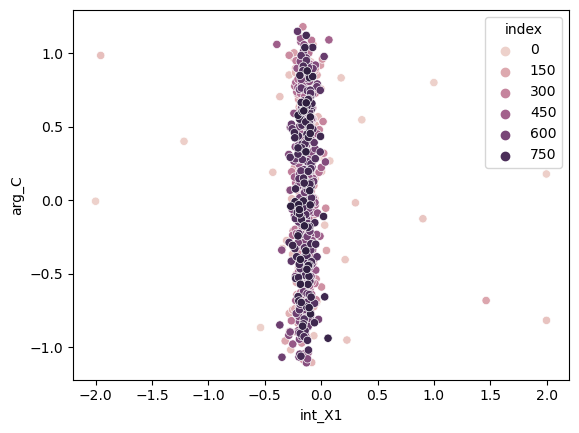

In [28]:
sns.scatterplot("int_X1", "arg_C",data=df, hue='index')

In [29]:
import pickle

In [30]:
# with open("results_pomps_paper_example.bin", "wb") as fd:
#     pickle.dump(results, fd)

<AxesSubplot:xlabel='int_X2', ylabel='arg_C'>

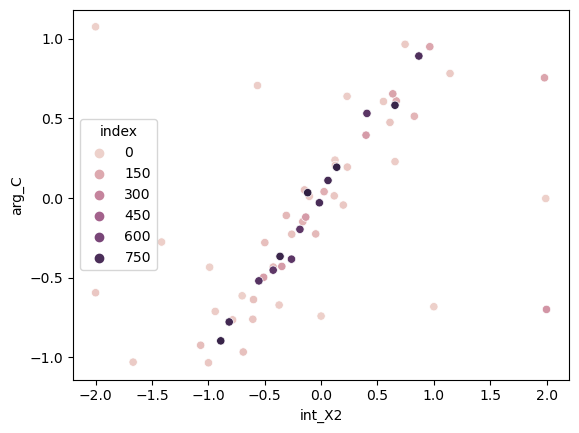

In [31]:
sns.scatterplot("int_X2", "arg_C",data=df, hue='index')

<AxesSubplot:xlabel='index', ylabel='trial_id'>

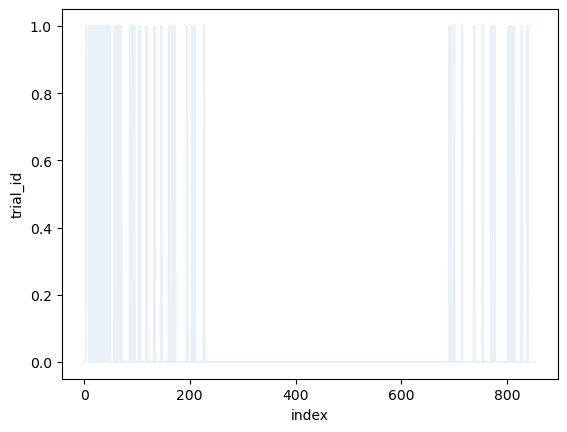

In [70]:
sns.lineplot(data=df, x="index", y="trial_id",alpha=0.1,)

<AxesSubplot:xlabel='trial_id', ylabel='index'>

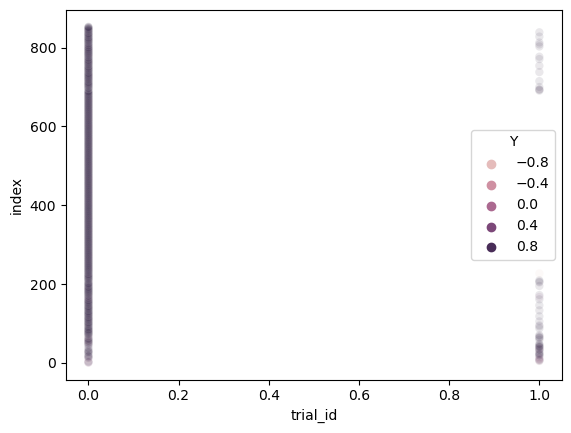

In [32]:
sns.scatterplot(data=df, x="trial_id", y="index", hue='Y',alpha=0.1,)

In [40]:
df["CUM_REG"] = (1-df['Y']).cumsum()
df["CUM_REG_M"] = df["CUM_REG"]/(df["index"] + 1)

<AxesSubplot:xlabel='index', ylabel='Y'>

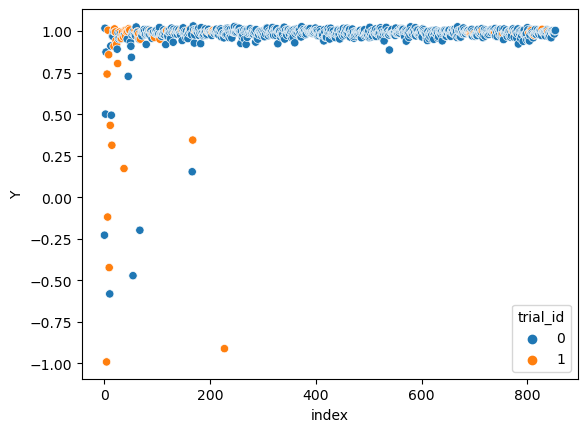

In [33]:
sns.scatterplot("index", "Y", data=df, hue='trial_id')

<AxesSubplot:xlabel='index', ylabel='CUM_REG'>

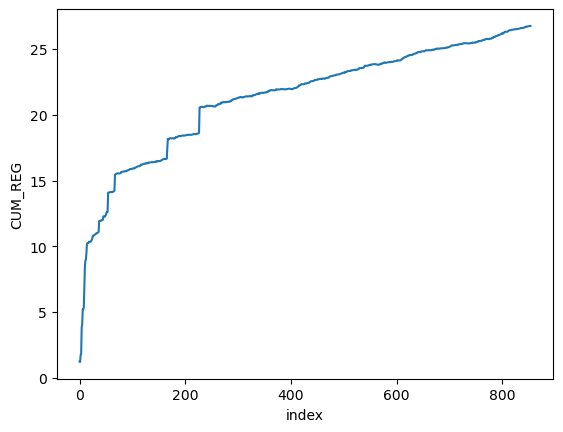

In [39]:
sns.lineplot("index", "CUM_REG", data=df)

<AxesSubplot:xlabel='index', ylabel='CUM_REG_M'>

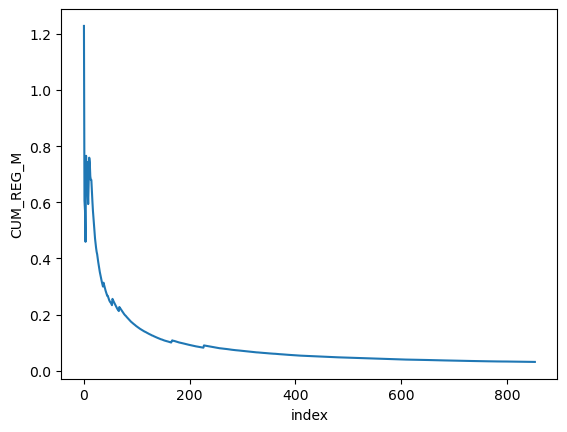

In [41]:
sns.lineplot("index", "CUM_REG_M", data=df)

In [28]:
import pickle 
with open('temp_res.bin', "wb") as fd: 
    pickle.dump(dict(results), fd)

In [29]:
for k,v in results.items():
    print(k, len(v))

trial_id 678
arg_C 677
int_X2 677
int_X1 677
Y 677


In [30]:
pomps_active[0]

(<pomps.fcm.FunctionalCausalModel at 0x7fb2f838aeb0>,
 <X1, {'C'}>)

In [48]:
 np.array(results["int_X2"])

array([-5.00000000e+00,  0.00000000e+00,  2.50000000e+00,  2.88187599e+00,
       -2.76688766e+00,  3.72562385e+00, -4.99735069e+00, -4.99917173e+00,
       -2.35988975e-01,  3.68504733e-01,  8.36614668e-01, -4.81353045e+00,
        3.33927691e-01, -5.80706224e-02, -5.91347873e-01,  5.36904335e-01,
        2.69833475e-01, -3.67526054e-01, -3.14037770e-01,  4.98794842e+00,
       -8.31889212e-01,  7.19358921e-01, -1.28295219e+00,  4.52464700e-01,
       -1.54751912e-01, -1.38887537e+00, -7.71355629e-01, -2.10756049e-01,
       -3.73264432e-01,  3.83386277e-02, -1.73288081e-02,  2.51333117e-01,
        2.73469537e-01, -1.96115673e-01,  5.13704360e-01, -4.44872618e+00,
       -9.30718184e-01,  1.60902369e+00,  1.47449344e-01, -3.17411184e+00,
        2.72266954e-01,  6.17187878e-04,  5.50645106e-02,  4.99877644e+00,
        4.61303234e+00,  3.61435980e-01,  5.00145018e-01,  1.08852375e+00,
       -5.09934723e-02, -6.52949512e-01,  4.99748611e+00,  7.56283581e-01,
        4.99973965e+00, -

In [53]:
np.array(results["arg_C"])[np.array(results["trial_id"])== 0].shape

(248,)

In [52]:
 np.array(results["int_X2"]).shape

(248,)

In [57]:
1/len(np.array(results["arg_C"])[np.array(results["trial_id"])== 0])

0.004032258064516129

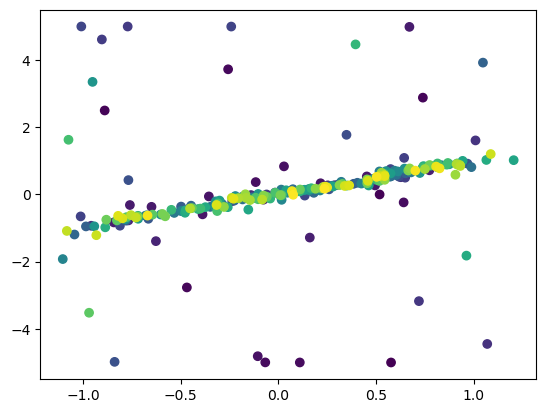

In [58]:
plt.scatter(np.array(results["arg_C"])[np.array(results["trial_id"])== 0], np.array(results["int_X2"]), c=np.arange(0,1,1/len(np.array(results["arg_C"])[np.array(results["trial_id"])== 0])))

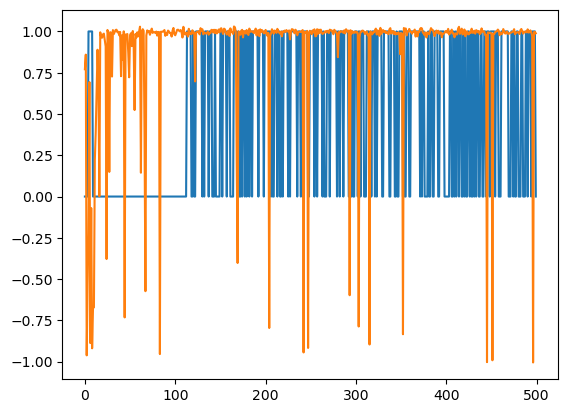

In [29]:
plt.plot(results["trial_id"][:len(results["Y"])])
plt.plot(results["Y"])


<AxesSubplot:xlabel='trial_id', ylabel='Y'>

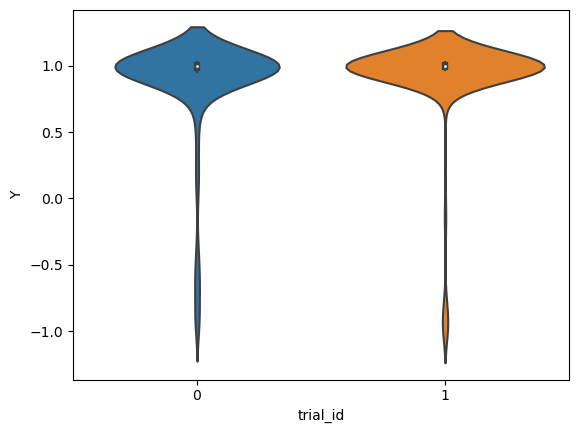

In [30]:
# plt.plot(results["trial_id"])
df = pd.DataFrame({"trial_id": results["trial_id"][:len(results["Y"])], "Y": results["Y"]})
sns.violinplot(data=df, x="trial_id", y="Y")
# df["trial_id"].plot()

In [31]:
df = pd.DataFrame(results)
df["Y"].plot()
df["trial_id"].plot()

ValueError: All arrays must be of the same length

<AxesSubplot:>

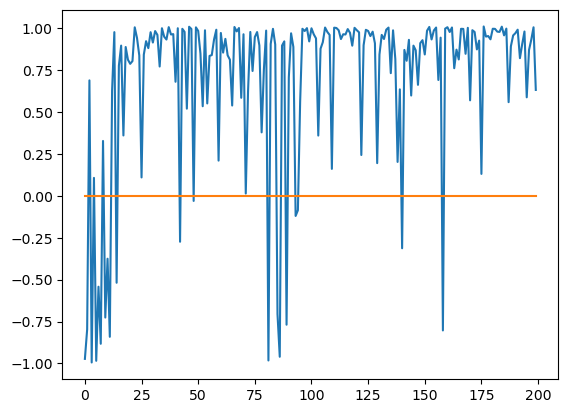

In [27]:
df = pd.DataFrame(results)
df["Y"].plot()
df["trial_id"].plot()

<AxesSubplot:>

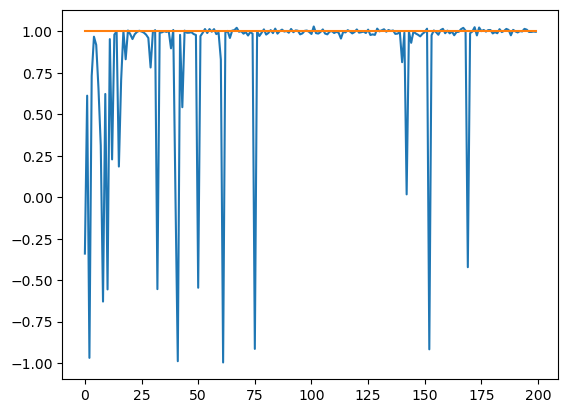

In [25]:
df = pd.DataFrame(results)
df["Y"].plot()
df["trial_id"].plot()

In [16]:
fcm_m.functors['X1'].functional.optimizer.best_x

AttributeError: 'function' object has no attribute 'optimizer'

In [24]:
sum([fcm_m.sample()["Y"] for i in range(1000)])/1000

buffer {}
{'C': tensor(0.3349)} {'U1': tensor(0.3719), 'U2': tensor(0.7512), 'C': tensor(0.3349)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.7771)} {'U1': tensor(0.7568), 'U2': tensor(0.8532), 'C': tensor(0.7771)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0657)} {'U1': tensor(-0.0564), 'U2': tensor(0.7644), 'C': tensor(-0.0657)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4529)} {'U1': tensor(-0.5128), 'U2': tensor(-0.6284), 'C': tensor(-0.4529)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5106)} {'U1': tensor(-0.4139), 'U2': tensor(0.7545), 'C': tensor(-0.5106)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8877)} {'U1': tensor(-0.7459), 'U2': tensor(0.3416), 'C': tensor(-0.8877)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1970)} {'U1': tensor(-0.4769), 'U2': tensor(0.4977), 'C': tensor(-0.1970)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4069)} {'U1': tensor(0.1989), 'U2': tensor(0.1013), 'C': tensor(0.4069)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8208)} {'U1': tensor(0.8586), 'U2': tensor(0.4828), 'C'

buffer {}
{'C': tensor(-0.0826)} {'U1': tensor(-0.1725), 'U2': tensor(-0.2601), 'C': tensor(-0.0826)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7305)} {'U1': tensor(-0.7769), 'U2': tensor(0.8565), 'C': tensor(-0.7305)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2101)} {'U1': tensor(0.1865), 'U2': tensor(0.7967), 'C': tensor(0.2101)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8682)} {'U1': tensor(-0.8046), 'U2': tensor(0.8763), 'C': tensor(-0.8682)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8163)} {'U1': tensor(0.7040), 'U2': tensor(0.7685), 'C': tensor(0.8163)} {'C'} {'C'} X1
buffer {}
{'C': tensor(1.1254)} {'U1': tensor(0.9448), 'U2': tensor(-0.6513), 'C': tensor(1.1254)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5405)} {'U1': tensor(0.3392), 'U2': tensor(-0.0293), 'C': tensor(0.5405)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.0810)} {'U1': tensor(0.1673), 'U2': tensor(-0.9943), 'C': tensor(0.0810)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4630)} {'U1': tensor(-0.3076), 'U2': tensor(0.3345), 'C':

buffer {}
{'C': tensor(-0.8831)} {'U1': tensor(-0.9199), 'U2': tensor(0.2879), 'C': tensor(-0.8831)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8514)} {'U1': tensor(0.9622), 'U2': tensor(-0.9442), 'C': tensor(0.8514)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4965)} {'U1': tensor(0.3669), 'U2': tensor(-0.6430), 'C': tensor(0.4965)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5541)} {'U1': tensor(0.4135), 'U2': tensor(-0.5419), 'C': tensor(0.5541)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.0034)} {'U1': tensor(-0.0057), 'U2': tensor(-0.2678), 'C': tensor(0.0034)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1918)} {'U1': tensor(0.2384), 'U2': tensor(-0.2486), 'C': tensor(0.1918)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7709)} {'U1': tensor(-0.7085), 'U2': tensor(-0.3898), 'C': tensor(-0.7709)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.9593)} {'U1': tensor(-0.9224), 'U2': tensor(-0.1760), 'C': tensor(-0.9593)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8826)} {'U1': tensor(-0.7230), 'U2': tensor(0.1477), 

buffer {}
{'C': tensor(0.5760)} {'U1': tensor(0.5169), 'U2': tensor(0.5109), 'C': tensor(0.5760)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8842)} {'U1': tensor(0.8401), 'U2': tensor(-0.7519), 'C': tensor(0.8842)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.9440)} {'U1': tensor(0.8113), 'U2': tensor(0.2589), 'C': tensor(0.9440)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.6413)} {'U1': tensor(0.4306), 'U2': tensor(-0.7571), 'C': tensor(0.6413)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.3826)} {'U1': tensor(0.4504), 'U2': tensor(0.8981), 'C': tensor(0.3826)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7998)} {'U1': tensor(-0.8659), 'U2': tensor(-0.1180), 'C': tensor(-0.7998)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5297)} {'U1': tensor(0.5546), 'U2': tensor(0.5995), 'C': tensor(0.5297)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0143)} {'U1': tensor(-0.0347), 'U2': tensor(0.8202), 'C': tensor(-0.0143)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4345)} {'U1': tensor(0.4569), 'U2': tensor(0.7620), 'C': tenso

buffer {}
{'C': tensor(-0.1189)} {'U1': tensor(-0.0938), 'U2': tensor(0.0194), 'C': tensor(-0.1189)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.6137)} {'U1': tensor(-0.6591), 'U2': tensor(-0.2989), 'C': tensor(-0.6137)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0524)} {'U1': tensor(-0.0660), 'U2': tensor(-0.5848), 'C': tensor(-0.0524)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5177)} {'U1': tensor(-0.6928), 'U2': tensor(-0.7024), 'C': tensor(-0.5177)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5313)} {'U1': tensor(-0.5620), 'U2': tensor(-0.8155), 'C': tensor(-0.5313)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1454)} {'U1': tensor(-0.0175), 'U2': tensor(0.0422), 'C': tensor(0.1454)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5630)} {'U1': tensor(-0.6514), 'U2': tensor(-0.4816), 'C': tensor(-0.5630)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.3591)} {'U1': tensor(0.3934), 'U2': tensor(-0.8009), 'C': tensor(0.3591)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4661)} {'U1': tensor(-0.5258), 'U2': tensor(-

buffer {}
{'C': tensor(0.9043)} {'U1': tensor(0.8370), 'U2': tensor(0.2800), 'C': tensor(0.9043)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4979)} {'U1': tensor(-0.5933), 'U2': tensor(-0.6975), 'C': tensor(-0.4979)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1955)} {'U1': tensor(0.3159), 'U2': tensor(0.1914), 'C': tensor(0.1955)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8228)} {'U1': tensor(0.8365), 'U2': tensor(-0.8311), 'C': tensor(0.8228)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1452)} {'U1': tensor(0.0165), 'U2': tensor(0.4228), 'C': tensor(0.1452)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.6527)} {'U1': tensor(0.6728), 'U2': tensor(-0.0269), 'C': tensor(0.6527)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.7418)} {'U1': tensor(0.8572), 'U2': tensor(0.5438), 'C': tensor(0.7418)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-1.1149)} {'U1': tensor(-0.9314), 'U2': tensor(-0.2623), 'C': tensor(-1.1149)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3576)} {'U1': tensor(-0.4068), 'U2': tensor(0.4516), 'C': te

buffer {}
{'C': tensor(-0.2605)} {'U1': tensor(-0.1974), 'U2': tensor(0.6820), 'C': tensor(-0.2605)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7080)} {'U1': tensor(-0.6539), 'U2': tensor(-0.5800), 'C': tensor(-0.7080)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1962)} {'U1': tensor(-0.1209), 'U2': tensor(-0.6859), 'C': tensor(-0.1962)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3317)} {'U1': tensor(-0.3432), 'U2': tensor(0.9108), 'C': tensor(-0.3317)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5358)} {'U1': tensor(0.6242), 'U2': tensor(-0.2945), 'C': tensor(0.5358)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4936)} {'U1': tensor(-0.5909), 'U2': tensor(0.0204), 'C': tensor(-0.4936)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8006)} {'U1': tensor(-0.7364), 'U2': tensor(0.6268), 'C': tensor(-0.8006)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4201)} {'U1': tensor(0.4380), 'U2': tensor(-0.8074), 'C': tensor(0.4201)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3488)} {'U1': tensor(-0.4807), 'U2': tensor(0.20

buffer {}
{'C': tensor(0.8632)} {'U1': tensor(0.8400), 'U2': tensor(-0.3019), 'C': tensor(0.8632)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5471)} {'U1': tensor(0.5901), 'U2': tensor(0.4975), 'C': tensor(0.5471)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4346)} {'U1': tensor(-0.3862), 'U2': tensor(-0.3856), 'C': tensor(-0.4346)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1115)} {'U1': tensor(0.0449), 'U2': tensor(-0.0992), 'C': tensor(-0.1115)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8716)} {'U1': tensor(-0.8064), 'U2': tensor(0.1268), 'C': tensor(-0.8716)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4199)} {'U1': tensor(-0.4835), 'U2': tensor(0.9957), 'C': tensor(-0.4199)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0742)} {'U1': tensor(-0.0154), 'U2': tensor(-0.1419), 'C': tensor(-0.0742)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2648)} {'U1': tensor(0.2363), 'U2': tensor(0.5823), 'C': tensor(0.2648)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.2307)} {'U1': tensor(-0.1762), 'U2': tensor(0.2684),

buffer {}
{'C': tensor(-0.7200)} {'U1': tensor(-0.7917), 'U2': tensor(0.8466), 'C': tensor(-0.7200)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4914)} {'U1': tensor(0.5409), 'U2': tensor(-0.5575), 'C': tensor(0.4914)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3602)} {'U1': tensor(-0.4817), 'U2': tensor(0.1817), 'C': tensor(-0.3602)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8527)} {'U1': tensor(0.9669), 'U2': tensor(0.8734), 'C': tensor(0.8527)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2812)} {'U1': tensor(0.2954), 'U2': tensor(-0.5136), 'C': tensor(0.2812)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1320)} {'U1': tensor(-0.1157), 'U2': tensor(0.4703), 'C': tensor(-0.1320)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8327)} {'U1': tensor(-0.9343), 'U2': tensor(0.7960), 'C': tensor(-0.8327)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4639)} {'U1': tensor(0.4223), 'U2': tensor(0.1996), 'C': tensor(0.4639)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1517)} {'U1': tensor(0.1631), 'U2': tensor(0.7737), 'C': 

buffer {}
{'C': tensor(0.7163)} {'U1': tensor(0.7433), 'U2': tensor(0.1738), 'C': tensor(0.7163)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4338)} {'U1': tensor(0.5537), 'U2': tensor(0.4018), 'C': tensor(0.4338)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1834)} {'U1': tensor(-0.1808), 'U2': tensor(-0.4139), 'C': tensor(-0.1834)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2210)} {'U1': tensor(0.1760), 'U2': tensor(-0.3728), 'C': tensor(0.2210)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2724)} {'U1': tensor(0.1958), 'U2': tensor(-0.3086), 'C': tensor(0.2724)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0632)} {'U1': tensor(-0.0409), 'U2': tensor(-0.3894), 'C': tensor(-0.0632)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5110)} {'U1': tensor(0.6527), 'U2': tensor(-0.9544), 'C': tensor(0.5110)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1151)} {'U1': tensor(-0.0863), 'U2': tensor(0.8031), 'C': tensor(-0.1151)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-1.0386)} {'U1': tensor(-0.9930), 'U2': tensor(-0.3480), 'C

buffer {}
{'C': tensor(-0.6770)} {'U1': tensor(-0.7848), 'U2': tensor(0.7386), 'C': tensor(-0.6770)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2808)} {'U1': tensor(0.3138), 'U2': tensor(-0.9476), 'C': tensor(0.2808)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.0668)} {'U1': tensor(0.1259), 'U2': tensor(-0.4100), 'C': tensor(0.0668)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3069)} {'U1': tensor(-0.1921), 'U2': tensor(0.5152), 'C': tensor(-0.3069)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4478)} {'U1': tensor(0.3611), 'U2': tensor(0.3289), 'C': tensor(0.4478)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.6927)} {'U1': tensor(-0.8606), 'U2': tensor(-0.6609), 'C': tensor(-0.6927)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1773)} {'U1': tensor(0.2386), 'U2': tensor(-0.4545), 'C': tensor(0.1773)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1060)} {'U1': tensor(-0.2210), 'U2': tensor(-0.7924), 'C': tensor(-0.1060)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0553)} {'U1': tensor(-0.1733), 'U2': tensor(0.2183), 

buffer {}
{'C': tensor(-0.3746)} {'U1': tensor(-0.4899), 'U2': tensor(0.5303), 'C': tensor(-0.3746)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1851)} {'U1': tensor(0.1951), 'U2': tensor(0.6746), 'C': tensor(0.1851)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5059)} {'U1': tensor(0.5822), 'U2': tensor(-0.6482), 'C': tensor(0.5059)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8479)} {'U1': tensor(-0.7988), 'U2': tensor(-0.7120), 'C': tensor(-0.8479)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4502)} {'U1': tensor(0.4586), 'U2': tensor(0.4371), 'C': tensor(0.4502)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3096)} {'U1': tensor(-0.4339), 'U2': tensor(0.3793), 'C': tensor(-0.3096)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-1.0461)} {'U1': tensor(-0.9740), 'U2': tensor(0.9017), 'C': tensor(-1.0461)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.3604)} {'U1': tensor(0.1088), 'U2': tensor(0.0483), 'C': tensor(0.3604)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4458)} {'U1': tensor(-0.4618), 'U2': tensor(0.5717), 'C'

buffer {}
{'C': tensor(0.9711)} {'U1': tensor(0.9691), 'U2': tensor(-0.2759), 'C': tensor(0.9711)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3080)} {'U1': tensor(-0.2169), 'U2': tensor(-0.0886), 'C': tensor(-0.3080)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1525)} {'U1': tensor(-0.0877), 'U2': tensor(-0.4516), 'C': tensor(-0.1525)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5952)} {'U1': tensor(-0.4424), 'U2': tensor(0.3671), 'C': tensor(-0.5952)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.2978)} {'U1': tensor(-0.4826), 'U2': tensor(0.6547), 'C': tensor(-0.2978)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.9360)} {'U1': tensor(-0.9212), 'U2': tensor(-0.2856), 'C': tensor(-0.9360)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7938)} {'U1': tensor(-0.8422), 'U2': tensor(-0.9802), 'C': tensor(-0.7938)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.7554)} {'U1': tensor(0.7457), 'U2': tensor(-0.3465), 'C': tensor(0.7554)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2671)} {'U1': tensor(0.3315), 'U2': tensor(-0.6

buffer {}
{'C': tensor(-0.6224)} {'U1': tensor(-0.6409), 'U2': tensor(-0.1234), 'C': tensor(-0.6224)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5573)} {'U1': tensor(-0.6019), 'U2': tensor(0.5680), 'C': tensor(-0.5573)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7920)} {'U1': tensor(-0.7927), 'U2': tensor(-0.7087), 'C': tensor(-0.7920)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1150)} {'U1': tensor(0.1502), 'U2': tensor(0.8838), 'C': tensor(0.1150)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1073)} {'U1': tensor(-0.0371), 'U2': tensor(0.3344), 'C': tensor(0.1073)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4883)} {'U1': tensor(0.5051), 'U2': tensor(0.9682), 'C': tensor(0.4883)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.9867)} {'U1': tensor(-0.9137), 'U2': tensor(-0.5154), 'C': tensor(-0.9867)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5191)} {'U1': tensor(0.3431), 'U2': tensor(-0.6637), 'C': tensor(0.5191)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.6618)} {'U1': tensor(0.4974), 'U2': tensor(0.2298), 'C

tensor(0.8081)

In [18]:
g = graph_under_mps[-2]
print(g[1])
MPSReductor.sufficiently_not_pomp(g[1], g[0])

<X2, {'C'}>
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}


False

In [27]:
g[0].uc_variables

{'U1'}

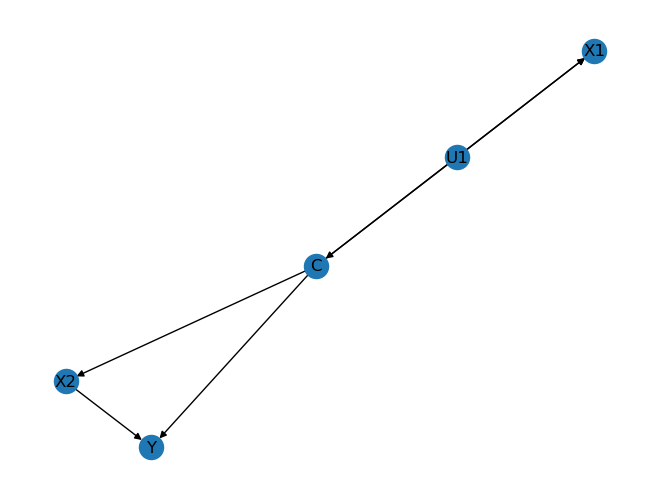

In [28]:
nx.draw(g[0], with_labels=True)

In [15]:
for idx, g in enumerate(graph_under_mps):
    print(idx, g[1])
    MPSReductor.sufficiently_not_pomp(g[1], g[0])

0 
1 <X2, set()>
set()
call
{'X2'} set()
{'X2'} {'X2'}
set()
call
{'X2'} set()
{'X2'} {'X2'}
2 <X2, {'C'}>
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}
3 <X2, {'X1'}>
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
4 <X1, set()>
set()
call
{'X1'} set()
{'X1'} {'X1'}
5 <X1, {'C'}>
6 <X2, {'X1'}>	<X1, {'C'}>
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}


In [10]:
mps = MixedPolicyScope(dict())
MPSDAGController.graph_under_mps(mps, ccg), mps

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7f8e610e3130>, True), )

In [8]:
g = graph_under_mps[0]
MPSReductor.sufficiently_not_pomp(g[1], g[0][0])

False

In [9]:
g

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7fed29561520>, True),
 <statin, set()>)

In [16]:
graph_under_mps[1]

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7fcde0cb9580>, True),
 <aspirin, {'age'}>)

In [18]:
MPSReductor.action_relevance_check(graph_under_mps[0][1], graph_under_mps[0][0][0])

True

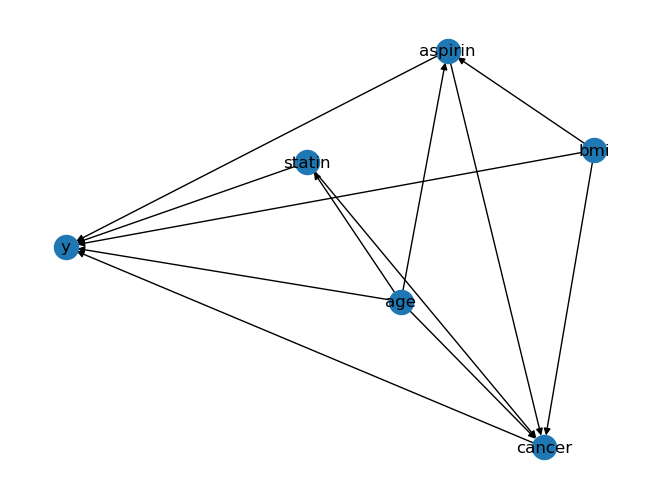

In [36]:
nx.draw(graph_under_mps[i][0], with_labels=True)

In [96]:
inter_segment = []
for inter in interventional_set:
    inter_segment += [[(inter, i) for i in contexts]]

In [104]:
iam = all_combs(inter_segment)
list(itertools.chain(*[(itertools.product(*iam[i])) for i in range(len(iam))], []))

[(),
 (('X1', ()),),
 (('X1', ('C2',)),),
 (('X1', ('C1',)),),
 (('X1', ('C2', 'C1')),),
 (('X2', ()),),
 (('X2', ('C2',)),),
 (('X2', ('C1',)),),
 (('X2', ('C2', 'C1')),),
 (('X1', ()), ('X2', ())),
 (('X1', ()), ('X2', ('C2',))),
 (('X1', ()), ('X2', ('C1',))),
 (('X1', ()), ('X2', ('C2', 'C1'))),
 (('X1', ('C2',)), ('X2', ())),
 (('X1', ('C2',)), ('X2', ('C2',))),
 (('X1', ('C2',)), ('X2', ('C1',))),
 (('X1', ('C2',)), ('X2', ('C2', 'C1'))),
 (('X1', ('C1',)), ('X2', ())),
 (('X1', ('C1',)), ('X2', ('C2',))),
 (('X1', ('C1',)), ('X2', ('C1',))),
 (('X1', ('C1',)), ('X2', ('C2', 'C1'))),
 (('X1', ('C2', 'C1')), ('X2', ())),
 (('X1', ('C2', 'C1')), ('X2', ('C2',))),
 (('X1', ('C2', 'C1')), ('X2', ('C1',))),
 (('X1', ('C2', 'C1')), ('X2', ('C2', 'C1')))]

In [100]:
list(itertools.product(interventional_set, contexts))

[('X1', ()),
 ('X1', ('C2',)),
 ('X1', ('C1',)),
 ('X1', ('C2', 'C1')),
 ('X2', ()),
 ('X2', ('C2',)),
 ('X2', ('C1',)),
 ('X2', ('C2', 'C1'))]